# New network with using spatial separable , depthwise , normal convolution, group convolution 

## import libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D ,DepthwiseConv2D ,SeparableConv2D 
from keras.layers import Activation, Flatten, Dropout ,Input,GlobalAveragePooling2D ,Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

## load dataset variables (training and testdataset)

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


## Print 10 classes output

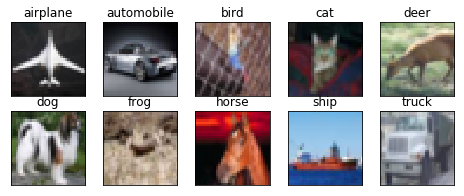

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## define to plot model history 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## define accuracy to print on plot

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## scale test and training dataset so that it will be on same range

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Followed the step mentioned in assignment steps - normal conv, separable- depthwise - and group conv. using the functional APIs

In [0]:
# Define the model as functional API not the Sequential one 

input = Input(shape=(32,32,3))

# Layer 1 -- using normal convolution 3X3
Conv1 = Convolution2D(64,3,3, activation ='relu', border_mode ='same',name ='NormalConv1')(input)
BN1 = BatchNormalization(name='bn1')(Conv1)

# Layer 2 -- using Spatially convolution 3X1
SapConv1 = Convolution2D(128,3,1, activation='relu',border_mode ='same', name='SapConv1')(BN1) #3x1
BN2 = BatchNormalization(name='bn2')(SapConv1)

# Layer 3 -- using Spatially convolution 1X3
SapConv2 = Convolution2D(128,1,3, activation='relu',border_mode ='same', name='SapConv2')(BN2) #3x1
BN3 = BatchNormalization(name='bn3')(SapConv2)


MaxPool3 = MaxPooling2D((2,2), name='pool3')(BN3)


# Layer 4 -- using Separable convolution
DepthConv = SeparableConv2D(64,3,3, activation='relu',border_mode ='same', name='DepthConv')(MaxPool3) 
BN4 = BatchNormalization(name='bn4')(DepthConv)

# Layer 6 - Group convolution - 
x = Convolution2D(128,3,3, activation='relu',border_mode ='same', name='x')(BN4) 
BNx = BatchNormalization(name='bn5')(x)

y = Convolution2D(64,5,5, activation='relu',border_mode ='same', name='y')(BNx) 
BNy = BatchNormalization(name='bn6')(x)

concat_1 =Concatenate(name ='cancat1')([x,BNy])
 
concat_output = Convolution2D(64,5,5, activation='relu',border_mode ='same', name='ycon1')(concat_1) 
concat_output = Convolution2D(64,1,1, activation='relu',border_mode ='same', name='ycon12')(concat_output) 

# Layer 7 - group convolution with dialation 

p = Convolution2D(128,3,3, activation='relu',border_mode ='same', name='p',dilation_rate=1)(concat_output) 
BNp = BatchNormalization(name='bn7')(p)


q = Convolution2D(128,3,3, activation='relu',border_mode ='same', name='q',dilation_rate=2)(BNp) 
BNq = BatchNormalization(name='bn8')(q)


concat_2 =Concatenate(name ='cancat2')([BNp,BNq])
 
concat_output_final = Convolution2D(64,3,3, activation='relu',border_mode ='same', name='ycon3')(concat_2) 
concat_output_final = Convolution2D(64,1,1, activation='relu',border_mode ='same', name='ycon13')(concat_output_final) 

MaxPool = MaxPooling2D((2,2), name='pool')(concat_output_final)

output1 = Convolution2D(10,8,8, activation='relu',border_mode ='same', name='y')(MaxPool) 

output1 = Convolution2D(10,1,1, activation='relu',border_mode ='same', name='youtput')(output1) 

output = GlobalAveragePooling2D()(output1)
output = Activation('softmax')(output)

model = Model(inputs=[input], outputs=[output])

model.summary()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="NormalConv1", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), activation="relu", name="SapConv1", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), activation="relu", name="SapConv2", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (3, 3), activation="relu", name="DepthConv", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
NormalConv1 (Conv2D)            (None, 32, 32, 64)   1792        input_31[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 64)   256         NormalConv1[0][0]                
__________________________________________________________________________________________________
SapConv1 (Conv2D)               (None, 32, 32, 128)  24704       bn1[0][0]                        
__________________________________________________________________________________________________
bn2 (Batch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="ycon3", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="ycon13", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), activation="relu", name="y", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", name="youtput", padding="same")`


## Compiling model

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0615 17:20:09.935184 139810596947840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Training network and plotting the history of model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':
W0615 17:20:16.441765 139810596947840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/50
390/390 [==============================] - 52s 133ms/step - loss: 1.6342 - acc: 0.4106 - val_loss: 1.4104 - val_acc: 0.5512
Epoch 2/50
390/390 [==============================] - 36s 91ms/step - loss: 0.9927 - acc: 0.6489 - val_loss: 1.1674 - val_acc: 0.6238
Epoch 3/50
390/390 [==============================] - 36s 91ms/step - loss: 0.7734 - acc: 0.7228 - val_loss: 0.8623 - val_acc: 0.7039
Epoch 4/50
390/390 [==============================] - 36s 92ms/step - loss: 0.6518 - acc: 0.7688 - val_loss: 0.7942 - val_acc: 0.7321
Epoch 5/50
390/390 [==============================] - 36s 91ms/step - loss: 0.5515 - acc: 0.8061 - val_loss: 0.7898 - val_acc: 0.7381
Epoch 6/50
390/390 [==============================] - 36s 92ms/step - loss: 0.4710 - acc: 0.8358 - val_loss: 0.7600 - val_acc: 0.7472
Epoch 7/50
390/390 [==============================] - 36s 92ms/step - loss: 0.4055 - acc: 0.8589 - val_loss: 0.6769 - val_acc: 0.7790
Epoch 8/50
390/390 [==============================] - 36s 91m

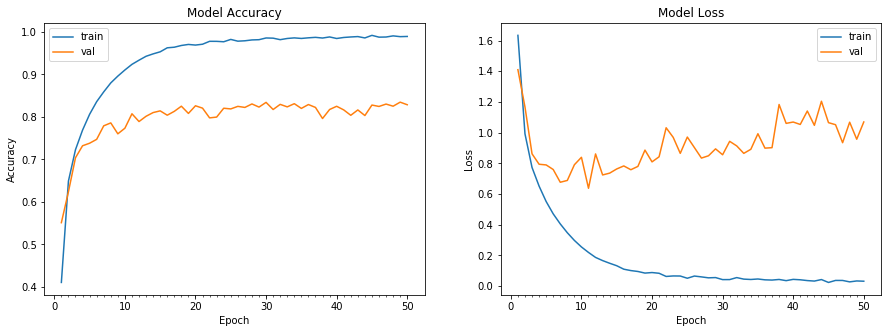

Accuracy on test data is: 82.86


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))